<a href="https://colab.research.google.com/github/allenwang0713/tebaml0315/blob/main/%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
path = "/content/drive/MyDrive/additional/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

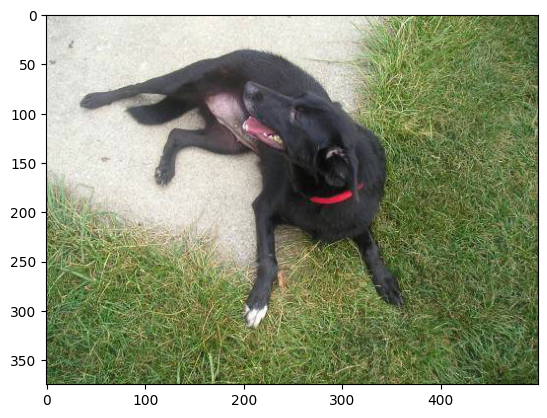

In [3]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[3000]))

In [4]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "filename":dogs[:900] + cats[:900],
    "class":["dog"] * 900 + ["cat"] * 900
})
validate = pd.DataFrame({
    "filename":dogs[900:950] + cats[900:950],
    "class":["dog"] * 50 + ["cat"] * 50
})
test = pd.DataFrame({
    "filename":dogs[950:1000] + cats[950:1000],
    "class":["dog"] * 50 + ["cat"] * 50
})

[preprocess](https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py)

caffe: 轉BGR後 - mean = [103.939, 116.779, 123.68], -1xx~+1xx間

tf: -1~1

torch: 

偷眼睛就得偷預處理

ImageDataGenerator一般會帶一個參數 rescale=1/255.0, 但我這裡是偷 我帶的是preprocessing_function

# 數據增強
妳的圖片太少的時候可以用原本圖片做出假圖片

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# 資料增強: zoom:放大(1.2) shear:偏斜(0.2) 水平翻轉
train_datagen = ImageDataGenerator(
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 測試資料是沒有動的
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 另外一個叫做flow_from_directory
# flow_from_dataframe: 檔案路徑要叫filename 答案class
training_set = train_datagen.flow_from_dataframe(
    train,
    ".",
    # 每一張圖片都縮到(224, 224): 根據當初imagenet的訓練大小
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    # 她會直接幫妳dog/cat這字串轉成0/1
    class_mode="sparse")
validate_set = test_datagen.flow_from_dataframe(
    validate,
    ".",
    # 每一張圖片都縮到(224, 224)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")
test_set = test_datagen.flow_from_dataframe(
    test,
    ".",
    # 每一張圖片都縮到(112, 112)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")

Found 1800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


(32, 224, 224, 3)


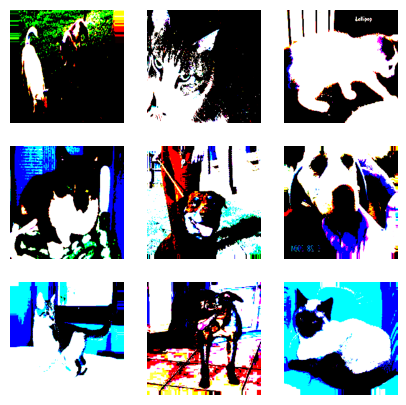

In [6]:
# 秀出訓練資料被數據增強以後產生的圖片
import matplotlib.pyplot as plt
batch = training_set.__next__()[0]
print(batch.shape)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i], cmap="gray")
    plt.axis("off")

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [24]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [25]:
# 控制訓練次數: 控制過擬合程度
# 不希望死背/看稀少, 檢查test
# 訓練次數過多反而會變差
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    # 檢查test資料, 如果我10次都沒有表現更好, 停
    EarlyStopping(patience=10, restore_best_weights=True)
]
# 不想要進度條, verbose=2
model.fit(training_set,
     epochs=150,
     validation_data=validate_set,
     callbacks=callbacks,
     verbose=2)

Epoch 1/150
57/57 - 28s - loss: 0.4268 - accuracy: 0.8294 - val_loss: 0.1433 - val_accuracy: 0.9700 - 28s/epoch - 493ms/step
Epoch 2/150
57/57 - 27s - loss: 0.2078 - accuracy: 0.9378 - val_loss: 0.0846 - val_accuracy: 0.9800 - 27s/epoch - 470ms/step
Epoch 3/150
57/57 - 27s - loss: 0.1625 - accuracy: 0.9478 - val_loss: 0.0656 - val_accuracy: 0.9800 - 27s/epoch - 467ms/step
Epoch 4/150
57/57 - 27s - loss: 0.1294 - accuracy: 0.9639 - val_loss: 0.0559 - val_accuracy: 0.9900 - 27s/epoch - 468ms/step
Epoch 5/150
57/57 - 27s - loss: 0.1175 - accuracy: 0.9683 - val_loss: 0.0483 - val_accuracy: 0.9900 - 27s/epoch - 471ms/step
Epoch 6/150
57/57 - 27s - loss: 0.0955 - accuracy: 0.9700 - val_loss: 0.0442 - val_accuracy: 0.9900 - 27s/epoch - 468ms/step
Epoch 7/150
57/57 - 27s - loss: 0.0897 - accuracy: 0.9744 - val_loss: 0.0422 - val_accuracy: 0.9900 - 27s/epoch - 467ms/step
Epoch 8/150
57/57 - 27s - loss: 0.0848 - accuracy: 0.9756 - val_loss: 0.0386 - val_accuracy: 0.9900 - 27s/epoch - 466ms/step


In [26]:
model.evaluate(x=test_set)

4/4 [==============================] - 1s 106ms/step - loss: 0.0485 - accuracy: 0.9900


[0.04854805767536163, 0.9900000095367432]

In [ ]:
# 你要看到機率不是always 1.00e+00
model.predict(test_set)

In [28]:
import numpy as np
def getdata(df):
    img_ori, img_preprocess, target = [], [], []
    for fn, c in zip(df["filename"], df["class"]):
        img = Image.open(fn).resize((224, 224)).convert("RGB")
        img_np = np.array(img)
        # original
        img_ori.append(img_np)
        img_np_pre = preprocess_input(img_np)
        # preprocess
        img_preprocess.append(img_np_pre)
        if c == "cat":
            target.append(0)
        else:
            target.append(1)
    return (np.array(img_ori), np.array(img_preprocess), np.array(target))
img_ori, x_test, y_test = getdata(test)
print(img_ori.shape)
print(x_test.shape)
print(y_test.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)
(100,)


In [29]:
pre = model.predict(img_ori).argmax(axis=-1)
pre

4/4 [==============================] - 1s 134ms/step


array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [30]:
np.nonzero(y_test != pre)

(array([ 3,  8, 14, 34, 37, 55, 97]),)

[ 3  8 14 34 37 55 97]


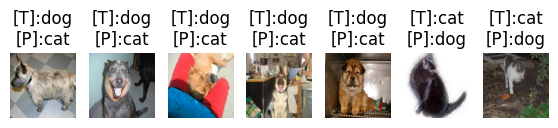

In [31]:
import numpy as np
trans = ["cat", "dog"]
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
print(idx)
plt.figure(figsize=(10, 10))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = img_ori[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])

url:https://i2.kknews.cc/W5fM7yHypujZx97SToYM54Zei5Fxd5kzzXQOMMI/0.jpg
1/1 [==============================] - 0s 26ms/step
cat 的機率: 1.0
dog 的機率: 0.0


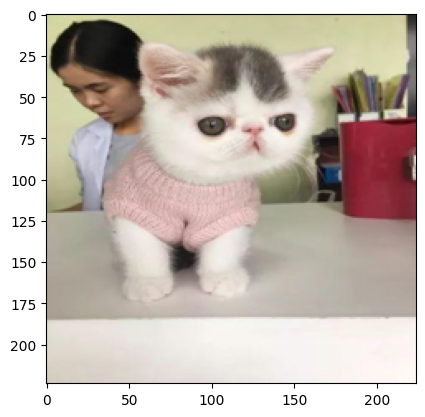

In [38]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)